In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf
print("GPUs:", len(tf.config.list_physical_devices('GPU'))>0)
print("CUDA available:", tf.test.is_built_with_cuda())

GPUs: True
CUDA available: True


In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from classification_models_3D.kkeras import Classifiers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.layers import Dropout, Dense, GlobalAveragePooling3D
from keras.models import Model
import pandas as pd
from pathlib import Path
import random
from scipy import ndimage

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("Setup complete!")

Setup complete!


In [4]:
# Dataset configuration
DATA_PATH = r"/tmjoa_3d/data/training_dataset"  # Update this path
TRAIN_DIR = os.path.join(DATA_PATH, "train")
VAL_DIR = os.path.join(DATA_PATH, "val")  # or "validation" if that's your folder name
TEST_DIR = os.path.join(DATA_PATH, "test")

# Model configuration
BACKBONE = 'resnet18'  # You can change this to any model from the library
INPUT_SHAPE = (224, 224, 224, 1)  # Single channel for your .nii.gz files
NUM_CLASSES = 2
USE_WEIGHTS = None  # No pre-trained weights - training from scratch

# Training configuration
BATCH_SIZE = 4  # Adjust based on your GPU memory
LEARNING_RATE = 0.001  # Slightly higher learning rate for training from scratch
PATIENCE = 20  # Increased patience since training from scratch takes longer
EPOCHS = 1  # More epochs needed when training from scratch

# Data augmentation (optional but recommended when training from scratch)
ENABLE_AUGMENTATION = True

In [5]:
def load_nii_file(file_path):
    """Load .nii.gz file and return numpy array"""
    try:
        img = nib.load(file_path)
        data = img.get_fdata()
        # print(f"Loaded {file_path}: shape {data.shape}")  # Debug print
        return data
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def normalize_volume(volume):
    """Normalize volume to [0, 1] range"""
    volume = volume.astype(np.float32)
    # Clip extreme values (optional)
    volume = np.clip(volume, np.percentile(volume, 1), np.percentile(volume, 99))
    # Normalize to [0, 1]
    volume = (volume - volume.min()) / (volume.max() - volume.min() + 1e-8)
    return volume

def preprocess_volume(volume):
    """Apply preprocessing steps to volume"""
    if volume is None:
        print("Warning: Volume is None")
        return np.zeros((224, 224, 224, 1), dtype=np.float32)
    
    # Print debug info
    #print(f"Input volume shape: {volume.shape}")
    
    # Ensure volume is 3D
    if len(volume.shape) == 4:
        # If 4D, take the first volume (assuming time series or multi-channel)
        volume = volume[:, :, :, 0]
    elif len(volume.shape) != 3:
        print(f"Warning: Unexpected volume shape {volume.shape}")
        return np.zeros((224, 224, 224, 1), dtype=np.float32)
    
    # Resize if needed
    if volume.shape != (224, 224, 224):
        from scipy import ndimage
        target_shape = (224, 224, 224)
        zoom_factors = [t/s for t, s in zip(target_shape, volume.shape)]
        volume = ndimage.zoom(volume, zoom_factors, order=1)
        #print(f"Resized volume to: {volume.shape}")
    
    # Normalize
    volume = normalize_volume(volume)
    
    # Add single channel dimension
    volume = np.expand_dims(volume, axis=-1)
    #print(f"Final volume shape: {volume.shape}")
    
    return volume

In [6]:
class NiiDataset:
    def __init__(self, data_dir, classes, preprocess_fn=None):
        self.data_dir = data_dir
        self.classes = classes
        self.preprocess_fn = preprocess_fn
        self.files = []
        self.labels = []
        
        self._load_file_list()
    
    def _load_file_list(self):
        """Load list of files and their labels"""
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.data_dir, class_name)
            if os.path.exists(class_dir):
                for file in os.listdir(class_dir):
                    if file.endswith('.nii') or file.endswith('.nii.gz'):
                        self.files.append(os.path.join(class_dir, file))
                        self.labels.append(class_idx)
        
        print(f"Found {len(self.files)} files in {len(self.classes)} classes")
        for idx, class_name in enumerate(self.classes):
            count = sum(1 for label in self.labels if label == idx)
            print(f"  Class {class_name}: {count} files")
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        
        # Load volume
        volume = load_nii_file(file_path)
        if volume is None:
            # Return dummy data if loading fails
            volume = np.zeros((224, 224, 224, 1))
        else:
            # Preprocess volume
            if self.preprocess_fn:
                volume = self.preprocess_fn(volume)
        
        return volume, label

In [7]:
def augment_volume(volume):
    """Apply random augmentations to volume - simplified version"""
    # Make sure volume is 3D
    if len(volume.shape) != 3:
        print(f"Warning: Expected 3D volume for augmentation, got shape {volume.shape}")
        return volume
    
    # Random flip
    if np.random.random() > 0.5:
        axis = np.random.choice(3)
        volume = np.flip(volume, axis=axis)
    
    # Random brightness adjustment
    if np.random.random() > 0.5:
        brightness = np.random.uniform(0.8, 1.2)
        volume = volume * brightness
        volume = np.clip(volume, 0, 1)
    
    # Add Gaussian noise
    if np.random.random() > 0.5:
        noise_std = np.random.uniform(0.0, 0.01)
        noise = np.random.normal(0, noise_std, volume.shape)
        volume = volume + noise
        volume = np.clip(volume, 0, 1)
    
    return volume

print("Augmentation functions updated!")

Augmentation functions updated!


In [8]:
# Define your class names
CLASS_NAMES = ["0", "1"]  # Update these to match your dataset structure

# Create datasets (just for getting file lists, not loading data)
print("Creating file lists...")
train_dataset = NiiDataset(TRAIN_DIR, CLASS_NAMES, preprocess_fn=None)
val_dataset = NiiDataset(VAL_DIR, CLASS_NAMES, preprocess_fn=None)
test_dataset = NiiDataset(TEST_DIR, CLASS_NAMES, preprocess_fn=None)

# Test loading a single volume to check shapes
print("\nTesting volume loading...")
if len(train_dataset) > 0:
    test_volume, test_label = train_dataset[0]
    print(f"Raw volume shape: {test_volume.shape}")
    processed_volume = preprocess_volume(test_volume)
    print(f"Processed volume shape: {processed_volume.shape}")
    print(f"Expected shape: {INPUT_SHAPE}")

Creating file lists...
Found 254 files in 2 classes
  Class 0: 114 files
  Class 1: 140 files
Found 73 files in 2 classes
  Class 0: 33 files
  Class 1: 40 files
Found 37 files in 2 classes
  Class 0: 16 files
  Class 1: 21 files

Testing volume loading...
Raw volume shape: (255, 255, 255)
Processed volume shape: (224, 224, 224, 1)
Expected shape: (224, 224, 224, 1)


In [9]:
import tensorflow as tf
from keras.utils import to_categorical, Sequence

class NiiDataGenerator(Sequence):
    def __init__(self, dataset, batch_size, preprocess_fn, preprocess_input_fn, 
                 num_classes, shuffle=True, augment=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.preprocess_fn = preprocess_fn
        self.preprocess_input_fn = preprocess_input_fn
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.dataset))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Initialize batch arrays
        X = np.zeros((len(batch_indices), *INPUT_SHAPE), dtype=np.float32)
        y = np.zeros((len(batch_indices), self.num_classes), dtype=np.float32)
        
        # Load and preprocess each sample in batch
        for i, idx in enumerate(batch_indices):
            try:
                # Load volume and label
                volume, label = self.dataset[idx]
                
                # Apply preprocessing
                if self.preprocess_fn:
                    volume = self.preprocess_fn(volume)
                
                # Ensure volume has correct shape
                if volume.shape != INPUT_SHAPE:
                    print(f"Warning: Volume shape {volume.shape} doesn't match expected {INPUT_SHAPE}")
                    volume = np.zeros(INPUT_SHAPE, dtype=np.float32)
                
                # Apply augmentation if enabled (only during training)
                if self.augment and ENABLE_AUGMENTATION:
                    # Remove channel dimension for augmentation
                    vol_for_aug = volume[:, :, :, 0]
                    vol_for_aug = augment_volume(vol_for_aug)
                    # Add channel dimension back
                    volume = np.expand_dims(vol_for_aug, axis=-1)
                
                # Apply model preprocessing - handle single volume
                volume_expanded = np.expand_dims(volume, axis=0)
                volume_processed = self.preprocess_input_fn(volume_expanded)[0]
                
                # Store in batch
                X[i] = volume_processed
                y[i] = to_categorical(label, self.num_classes)
                
            except Exception as e:
                print(f"Error processing sample {idx}: {e}")
                # Use zeros for failed samples
                X[i] = np.zeros(INPUT_SHAPE, dtype=np.float32)
                y[i] = to_categorical(0, self.num_classes)  # Default to class 0
        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

print("Data generator class created!")

Data generator class created!


In [10]:
# Get model and preprocessing function
modelPoint, preprocess_input = Classifiers.get(BACKBONE)

# Create base model without pre-trained weights
base_model = modelPoint(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights=None,  # No pre-trained weights
)

# Add custom head for your classification task
x = base_model.layers[-1].output
x = GlobalAveragePooling3D()(x)

# Add more dropout and regularization since we're training from scratch
x = Dropout(0.6)(x)  # Higher dropout
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)  # Added L2 regularization
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
x = Dense(NUM_CLASSES, activation='softmax' if NUM_CLASSES > 2 else 'sigmoid')(x)

# Create final model
model = Model(inputs=base_model.inputs, outputs=x)

# Compile model with different optimizer settings for training from scratch
from keras.optimizers import Adam
optimizer = Adam(
    learning_rate=LEARNING_RATE,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

loss = 'categorical_crossentropy' if NUM_CLASSES > 2 else 'binary_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Print model summary
model.summary()
print(f"\nTotal parameters: {model.count_params():,}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 224, 224,  │          0 │ -                 │
│                     │ 224, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 224, 224,  │          3 │ data[0][0]        │
│ (BatchNormalizatio… │ 224, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d      │ (None, 230, 230,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding3D)     │ 230, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv3D)      │ (None, 112, 112,  │     21,952 │ zero_padding3d[0… │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 112, 112,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 112, 112,  │          0 │ bn0[0][0]         │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_1    │ (None, 114, 114,  │          0 │ relu0[0][0]       │
│ (ZeroPadding3D)     │ 114, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 56, 56,    │          0 │ zero_padding3d_1… │
│ (MaxPooling3D)      │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 56, 56,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 56, 56,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_2    │ (None, 58, 58,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding3D)     │ 58, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 56, 56,    │    110,592 │ zero_padding3d_2… │
│ (Conv3D)            │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 56, 56,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 56, 56,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_3    │ (None, 58, 58,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding3D)     │ 58, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 56, 56,    │    110,592 │ zero_padding3d_3… │
│ (Conv3D)            │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 56, 56,    │      4,096 │ stage1_unit1_rel

 Total params: 33,334,853 (127.16 MB)

 Trainable params: 33,326,915 (127.13 MB)

 Non-trainable params: 7,938 (31.01 KB)


Total parameters: 33,334,853


In [11]:
# Create data generators
print("Creating data generators...")

# Training generator with augmentation
train_generator = NiiDataGenerator(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    preprocess_fn=preprocess_volume,
    preprocess_input_fn=preprocess_input,
    num_classes=NUM_CLASSES,
    shuffle=True,
    augment=True
)

# Validation generator without augmentation
val_generator = NiiDataGenerator(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    preprocess_fn=preprocess_volume,
    preprocess_input_fn=preprocess_input,
    num_classes=NUM_CLASSES,
    shuffle=False,
    augment=False
)

# Test generator without augmentation
test_generator = NiiDataGenerator(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    preprocess_fn=preprocess_volume,
    preprocess_input_fn=preprocess_input,
    num_classes=NUM_CLASSES,
    shuffle=False,
    augment=False
)

print(f"Created generators:")
print(f"  Train batches: {len(train_generator)}")
print(f"  Validation batches: {len(val_generator)}")
print(f"  Test batches: {len(test_generator)}")

Creating data generators...
Created generators:
  Train batches: 64
  Validation batches: 19
  Test batches: 10


In [12]:
# Create callbacks optimized for training from scratch
callbacks = [
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # More aggressive learning rate reduction for training from scratch
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,  # More aggressive reduction
        patience=PATIENCE//3,  # Reduce patience
        min_lr=1e-8,
        verbose=1,
        mode='min'
    ),
    CSVLogger('training_log.csv'),
    EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        verbose=1,
        restore_best_weights=True,
        mode='min'
    ),
    # Add learning rate scheduler for better training from scratch
    tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: LEARNING_RATE * (0.95 ** epoch),
        verbose=0
    )
]

In [13]:
# Train model using generators
print("Starting training with data generators...")

try:
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )
    print("Training completed!")
except Exception as e:
    print(f"Training error: {e}")
    print("Checking first batch...")
    # Try to get first batch to debug
    try:
        X_batch, y_batch = train_generator[0]
        print(f"Batch shapes: X={X_batch.shape}, y={y_batch.shape}")
    except Exception as batch_error:
        print(f"Batch error: {batch_error}")

Starting training with data generators...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747330050.898219    5654 service.cc:145] XLA service 0x7fbe10004460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747330050.898275    5654 service.cc:153]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
I0000 00:00:1747330119.641530    5654 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4951 - loss: 5.0704
Epoch 1: val_loss improved from inf to 396.18872, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 716s 9s/step - accuracy: 0.4959 - loss: 5.0618 - val_accuracy: 0.4521 - val_loss: 396.1887 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
Training completed!


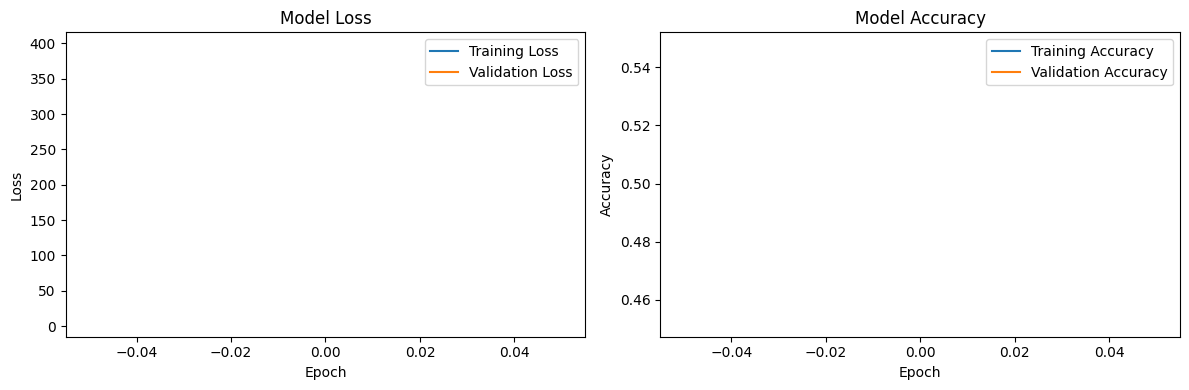

In [14]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Load best model
model.load_weights('best_model.keras')

# Evaluate on test set using generator
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions for all test samples
print("Getting predictions...")
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels (need to iterate through test generator)
y_true = []
test_generator.shuffle = False  # Ensure consistent order
for i in range(len(test_generator)):
    _, batch_y = test_generator[i]
    y_true.extend(np.argmax(batch_y, axis=1))
y_true = np.array(y_true)

# Trim predictions to match true labels (in case of incomplete last batch)
y_pred_classes = y_pred_classes[:len(y_true)]

# Generate classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nTest Set Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES))

Evaluating on test set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - accuracy: 0.7134 - loss: 186.6150
Test Loss: 376.9329
Test Accuracy: 0.4324
Getting predictions...
10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60        16
           1       0.00      0.00      0.00        21

    accuracy                           0.43        37
   macro avg       0.22      0.50      0.30        37
weighted avg       0.19      0.43      0.26        37



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


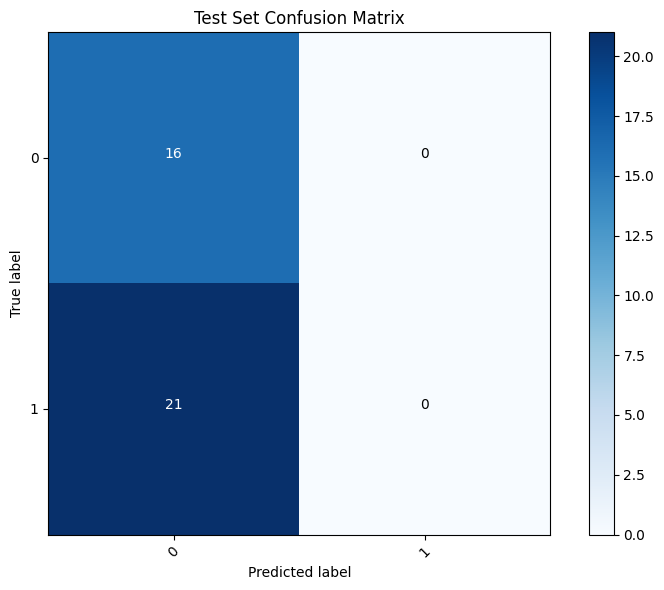

In [16]:
import itertools

# Confusion matrix for test set
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Test Set Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(CLASS_NAMES))
plt.xticks(tick_marks, CLASS_NAMES, rotation=45)
plt.yticks(tick_marks, CLASS_NAMES)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add text annotations
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [18]:
# Save the final model
model.save('final_3d_model.keras')
print("Model saved successfully!")

# Save training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("Training history saved!")

Model saved successfully!
Training history saved!


In [19]:
def predict_single_volume(model, file_path):
    """Predict class for a single .nii.gz file"""
    # Load and preprocess volume
    volume = load_nii_file(file_path)
    if volume is None:
        return None
    
    volume = preprocess_volume(volume)
    volume = preprocess_input(np.expand_dims(volume, axis=0))
    
    # Make prediction
    pred = model.predict(volume, verbose=0)
    pred_class = np.argmax(pred, axis=1)[0]
    confidence = pred[0][pred_class]
    
    return {
        'predicted_class': CLASS_NAMES[pred_class],
        'confidence': confidence,
        'probabilities': {name: prob for name, prob in zip(CLASS_NAMES, pred[0])}
    }

# Example usage
result = predict_single_volume(model, "/tmjoa_3d/data/5_adjustedBG/63-700385 R_adjustedBG.nii.gz")
print(result)

{'predicted_class': '0', 'confidence': 1.0, 'probabilities': {'0': 1.0, '1': 0.0}}


In [20]:
from keras.models import load_model

# Load the best model (recommended)
model = load_model('best_model.keras')

# Or load the final model
model = load_model('final_3d_model.keras')

print("Model loaded successfully!")
print(model.summary())

Model loaded successfully!


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 224, 224,  │          0 │ -                 │
│                     │ 224, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 224, 224,  │          3 │ data[0][0]        │
│ (BatchNormalizatio… │ 224, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d      │ (None, 230, 230,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding3D)     │ 230, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv3D)      │ (None, 112, 112,  │     21,952 │ zero_padding3d[0… │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 112, 112,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 112, 112,  │          0 │ bn0[0][0]         │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_1    │ (None, 114, 114,  │          0 │ relu0[0][0]       │
│ (ZeroPadding3D)     │ 114, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 56, 56,    │          0 │ zero_padding3d_1… │
│ (MaxPooling3D)      │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 56, 56,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 56, 56,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_2    │ (None, 58, 58,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding3D)     │ 58, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 56, 56,    │    110,592 │ zero_padding3d_2… │
│ (Conv3D)            │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 56, 56,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 56, 56,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_3    │ (None, 58, 58,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding3D)     │ 58, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 56, 56,    │    110,592 │ zero_padding3d_3… │
│ (Conv3D)            │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 56, 56,    │      4,096 │ stage1_unit1_rel

 Total params: 99,988,685 (381.43 MB)

 Trainable params: 33,326,915 (127.13 MB)

 Non-trainable params: 7,938 (31.01 KB)

 Optimizer params: 66,653,832 (254.26 MB)

None
